In [ ]:
# import needed libraries
import numpy as np
import argparse
import time
from random import shuffle
import random
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/myDrive/')

Drive already mounted at /content/myDrive/; to attempt to forcibly remount, call drive.mount("/content/myDrive/", force_remount=True).


In [ ]:
# go to folder with /data and /utils
cd myDrive/MyDrive/ZSL

[Errno 2] No such file or directory: 'myDrive/MyDrive/ZSL'
/content/myDrive/MyDrive/ZSL


### Read test data

In [ ]:
from scipy import io
att_splits=io.loadmat('./data/AWA2/binaryAtt_splits.mat')
# retrieve all the class names
classes_names = [a[0] for a in np.squeeze(att_splits['allclasses_names'])]
# create helper dictionary from class id to class name
id_to_name = {i:name for (i,name) in enumerate(classes_names)}

In [ ]:
from utils import data_loader
import importlib
# load /utils/data_loader
importlib.reload(data_loader)
# load the data
trainDataX, trainDataLabels, trainDataAttrs, testDataX, testDataLabels, testDataAttrs = data_loader.DataLoader("./data/CUB", binary=False).load()
trainDataX = (trainDataX - np.mean(trainDataX)) / np.std(trainDataX) # normalize image embeddings
testDataX = (testDataX - np.mean(testDataX)) / np.std(testDataX) # normalize image embeddings

# get the number of testing examples
test_size = len(testDataLabels)

In [ ]:
# create class_id:attribute dictionary
class_attr_dict = {}
for A, B in zip(trainDataLabels, trainDataAttrs):
    # training classes
    class_attr_dict[A] = B
for A, B in zip(testDataLabels, testDataAttrs):
    # testing classes
    class_attr_dict[A] = B

# sort it from smallest to highest id
keys = sorted(class_attr_dict)
class_attr_dict = {i: class_attr_dict[i] for i in keys}
class_attr_dict.keys()

# create dictionary from attributes to a class id
atrr_to_class = {v.tobytes(): k for k, v in class_attr_dict.items()}
all_class_atrs = class_attr_dict.values()

In [ ]:
# create class_id:attribute dictionary for test classes
test_attributes = {}
for A, B in zip(testDataLabels, testDataAttrs):
    test_attributes[A] = B
test_attributes = test_attributes.values()

### Load the model

In [ ]:
# load saved from experiments model
model = load_model('attributes_classificator')

### Evaluate

In [ ]:
# all classes names in test dataset
classes = [id_to_name[label] for label in np.unique(testDataLabels)]
# helper: class name (str) to id in confusion matrix dictionary
class_to_conf_matrix = {cl:i for i,cl in enumerate(classes)}

In [ ]:
def similarity(class_attribute, prediction):
    ''' calulate similarity between predicted and actual attribute distribution '''
    #assert(len(class_attribute) == len(prediction))
    sim = 1
    # iterate through actual test class attribute representation
    for i, att in enumerate(class_attribute):
        # for a single attribute of a attribute representation do:
        if att==1:
            # if ground truth is 1, take the probability
            sim*=prediction[i]
        else:
            # assert(att==0)
            # else, take 1-p
            sim*=(1-prediction[i])

    # return product of probabilities
    return sim

def evaluate(pred, printing=False):
  ''' get accuracy of the given model given its prediction of test dataset '''
  correct = 0
  confusion_matrix = [[0]*10 for i in range(10)]

  # iterate through each test example
  for id in range(test_size-1):
    # get similarity score
    similarities = [similarity(att, pred[id]) for att in test_attributes]
    assert(len(similarities)==10)

    # take the id of the max similaity
    id_predicted = np.argmax(similarities)
    # retrive the class id of the max similarity
    class_prediction = atrr_to_class[list(test_attributes)[id_predicted].tobytes()]

    # optional printing
    if printing:
      print(f"predicted class: {class_prediction} real class : {testDataLabels[id]}")
      print(f"predicted class: {id_to_name[class_prediction]} real class : {id_to_name[testDataLabels[id]]}")
      print(f"CORRECT:::??? ->>> {class_prediction == testDataLabels[id]}")

    # if correct, add to correct variable
    if class_prediction == testDataLabels[id]:
      correct += 1

    # update confusion matrix
    confusion_matrix[class_to_conf_matrix[id_to_name[testDataLabels[id]]]][class_to_conf_matrix[id_to_name[class_prediction]]] += 1

  # return accuracy
  return correct/test_size, confusion_matrix

In [ ]:
  # get prediction on test set
  pred = model.predict(testDataX)

  # transform to fit the attributes shape and form
  pred = list(np.array(pred).T)[0]

248/248 [==============================] - 3s 5ms/step


In [ ]:
# evaluate predicion from test dataset
acc, conf_matrix = evaluate(pred)

In [ ]:
# get accuracy
acc

0.4199418678124605

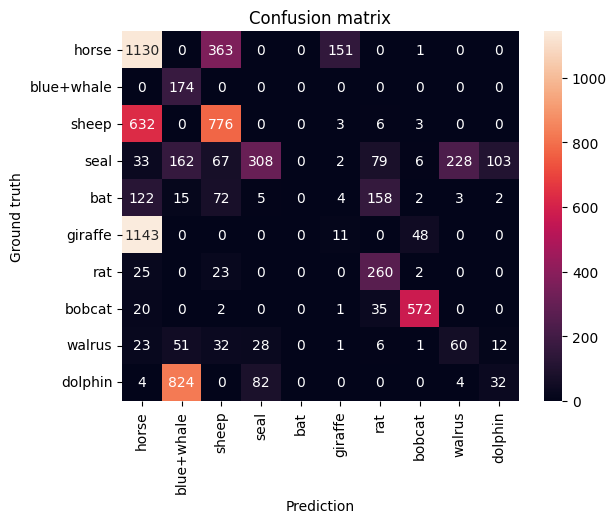

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualise confusion matrix
ax = plt.axes()
sns.heatmap(conf_matrix, ax = ax, xticklabels = classes, yticklabels = classes, annot=True, fmt='d')
ax.set_title('Confusion matrix')
ax.set_ylabel('Ground truth')
ax.set_xlabel('Prediction')
plt.show()

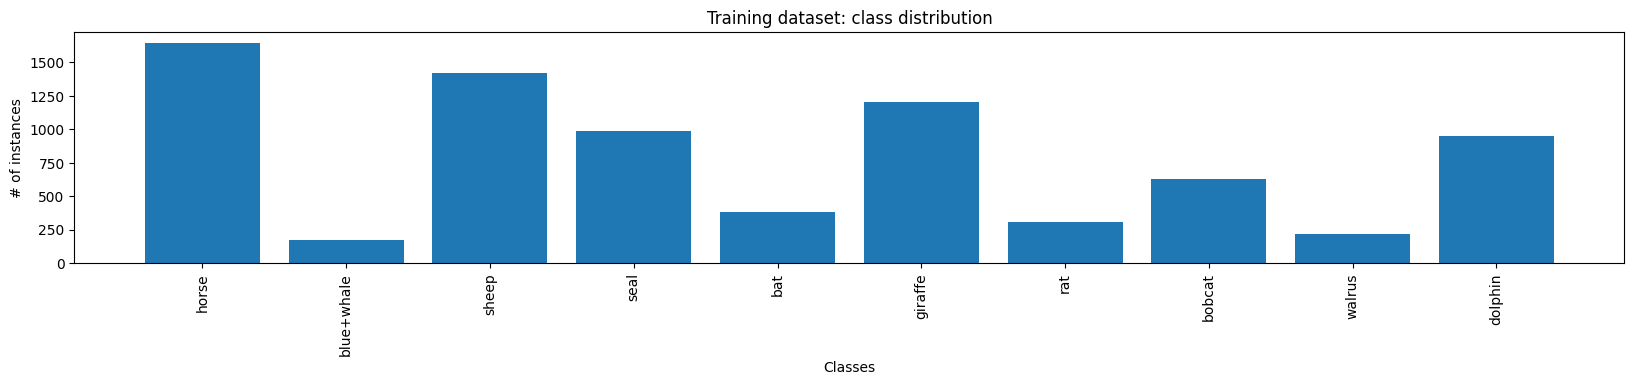

In [ ]:
# visualise test dataset class distribution
labels_with_counts = np.unique(testDataLabels, return_counts=True)
counts = labels_with_counts[1]
classes_labels = [id_to_name[id] for id in labels_with_counts[0]]
plt.figure(figsize=(20, 3))
plt.bar(classes_labels, counts)
plt.xticks(classes, rotation='vertical')
plt.xlabel('Classes')
plt.ylabel("# of instances")
plt.title('Training dataset: class distribution')
plt.show()